In [15]:
R.Version()
options(warn = -1)

$platform
[1] "x86_64-w64-mingw32"

$arch
[1] "x86_64"

$os
[1] "mingw32"

$system
[1] "x86_64, mingw32"

$status
[1] ""

$major
[1] "3"

$minor
[1] "5.2"

$year
[1] "2018"

$month
[1] "12"

$day
[1] "20"

$`svn rev`
[1] "75870"

$language
[1] "R"

$version.string
[1] "R version 3.5.2 (2018-12-20)"

$nickname
[1] "Eggshell Igloo"

In [11]:
##load library

library(Seurat)
library(dplyr)
library(ggplot2)
library(sctransform)
library(ComplexHeatmap)
library(circlize)
library("hdf5r")

In [21]:
setwd("YOUR_WORK_DIRECTORY")
##for Tumor samples
##Following the instruction of cellranger 3.0 https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/using/aggregate; #--normalize=mapped (default)
##We merge the two process_data Tumor_PBS(Tumor_PBS_molecule_info.h5) and Tumor_D-CAN(Tumor_D-CAN_molecule_info.h5)##
##We then use the merged h5 file ("Merged_Tumor_filtered_feature_bc_matrix.h5") as the import 
Tumor_merged_path <- ("Merged_Tumor_filtered_feature_bc_matrix.h5")
SAT_merged_path <- ("Merged_Tumor_filtered_feature_bc_matrix.h5")
SAT_merged_data <- Read10X_h5(SAT_merged_path)
##Create Seurat Object
SAT_merged <- CreateSeuratObject(counts = SAT_merged_data,min.cells=1)
SAT_merged[["percent.mt"]] <- PercentageFeatureSet(object = SAT_merged, pattern = "^mt-")
##only keep mitochondrial <= 50, nCount_RNA <= 30000,  nFeature_RNA > 0  )
#set fixed seed #shape might have slightly difference between the paper.
SAT_merged_filtered <- subset(x = SAT_merged, subset = percent.mt <= 50 & nCount_RNA <= 30000 & nFeature_RNA > 0)

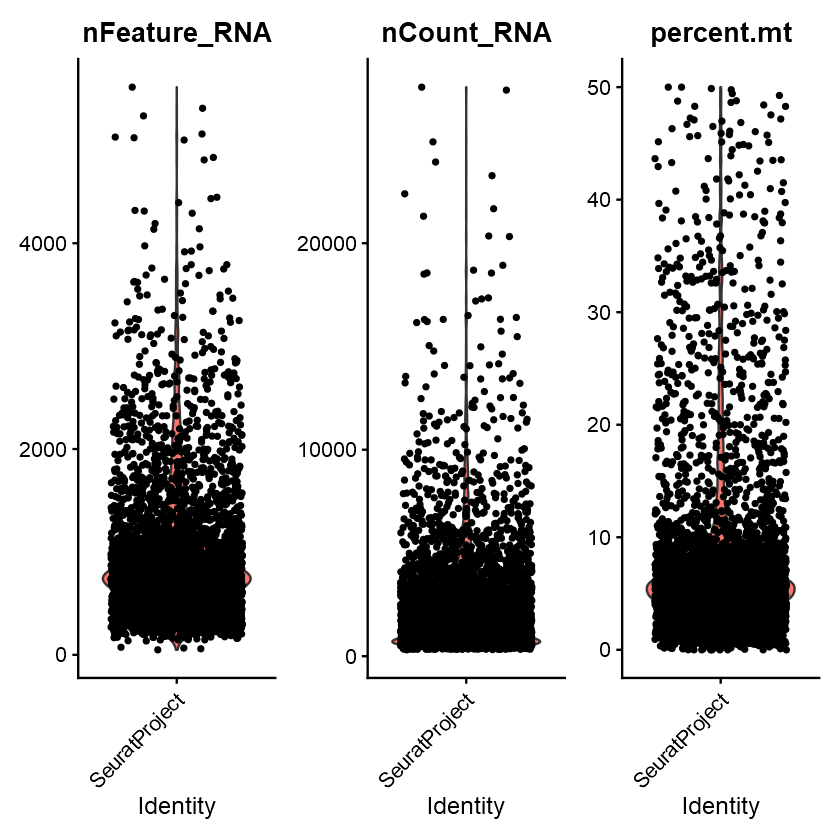

In [22]:
VlnPlot(object = SAT_merged_filtered, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

In [24]:
##label the cells, due to the merged order "-1" is "PBS" and "-2" is "D-CAN"
label_sim <- rep("PBS", length(SAT_merged_filtered$orig.ident))
label_sim[grep("-2",names(SAT_merged_filtered$orig.ident))] <- "DCAN"

In [ ]:
SAT_merged_filtered <- FindNeighbors(object = SAT_merged_filtered, dims = 1:20, verbose = FALSE)
SAT_merged_filtered <- FindClusters(object = SAT_merged_filtered, verbose = FALSE, resolution = 0.6 )

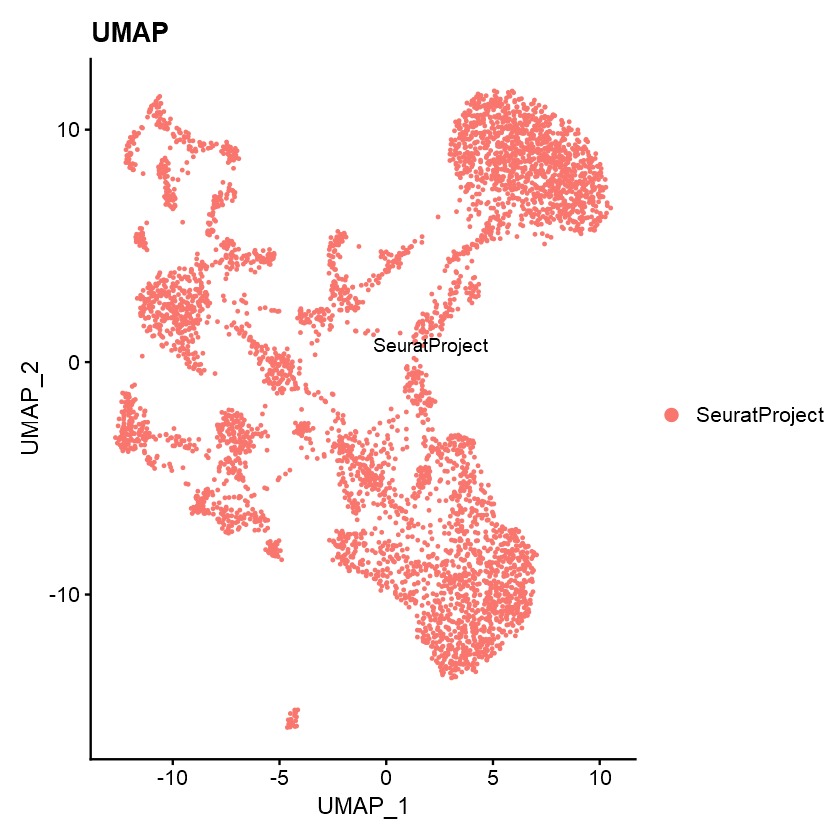

In [32]:
SAT_merged_filtered$sample.indent <- label_sim
set.seed(1) ##Forget to set orginal seed in the manuscript. Thus the shape might be sightly different
SAT_merged_filtered <- SCTransform(object = SAT_merged_filtered,verbose = FALSE)
SAT_merged_filtered <- RunPCA(object = SAT_merged_filtered,ndims.print = 1:20, nfeatures.print = 10,verbose = FALSE)
#Run UMAP
SAT_merged_filtered <- RunUMAP(object = SAT_merged_filtered, dims = 1:20, min.dist = 0.75,reduction.name = "UMAP",verbose = FALSE)

In [102]:
SAT_merged_filtered <- FindNeighbors(object = SAT_merged_filtered, dims = 1:20, verbose = FALSE)
SAT_merged_filtered <- FindClusters(object = SAT_merged_filtered, verbose = FALSE, resolution = 0.6 )

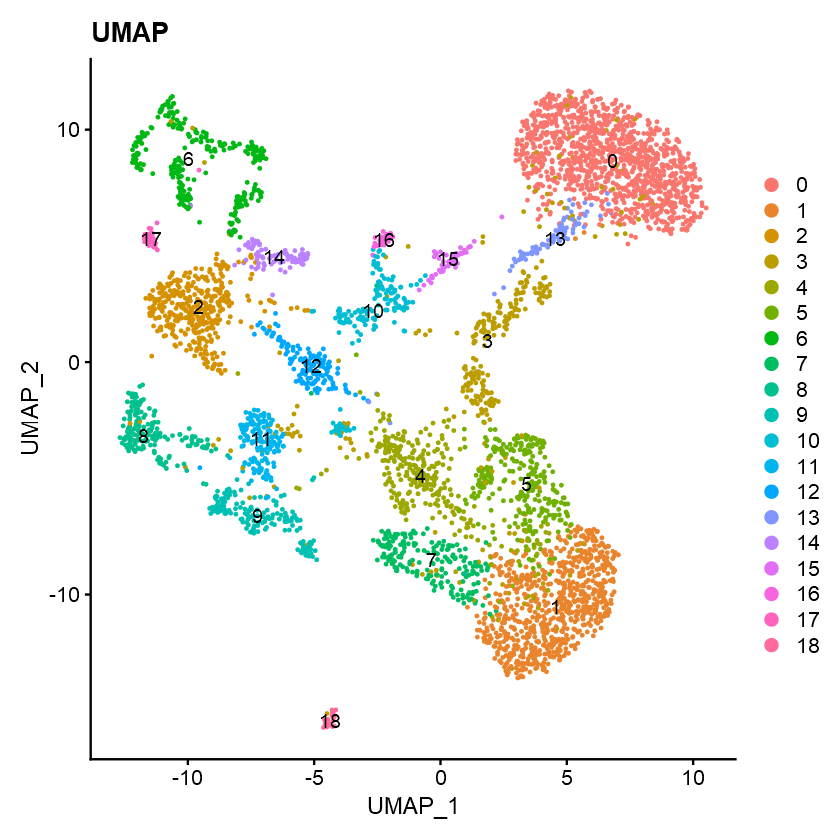

In [103]:
DimPlot(object = SAT_merged_filtered, label = TRUE,reduction = "UMAP", pt.size = 0.3) + ggtitle(label = "UMAP")

In [104]:
UMAP_score_1 <- SAT_merged_filtered@reductions$UMAP@cell.embeddings[,1]
UMAP_score_2 <- SAT_merged_filtered@reductions$UMAP@cell.embeddings[,2]
##Adjust for visulization##
SAT_merged_filtered@reductions$UMAP@cell.embeddings[,1] <- -UMAP_score_1
SAT_merged_filtered@reductions$UMAP@cell.embeddings[,2] <- UMAP_score_2
UMAP_score_1 <- SAT_merged_filtered@reductions$UMAP@cell.embeddings[,1]

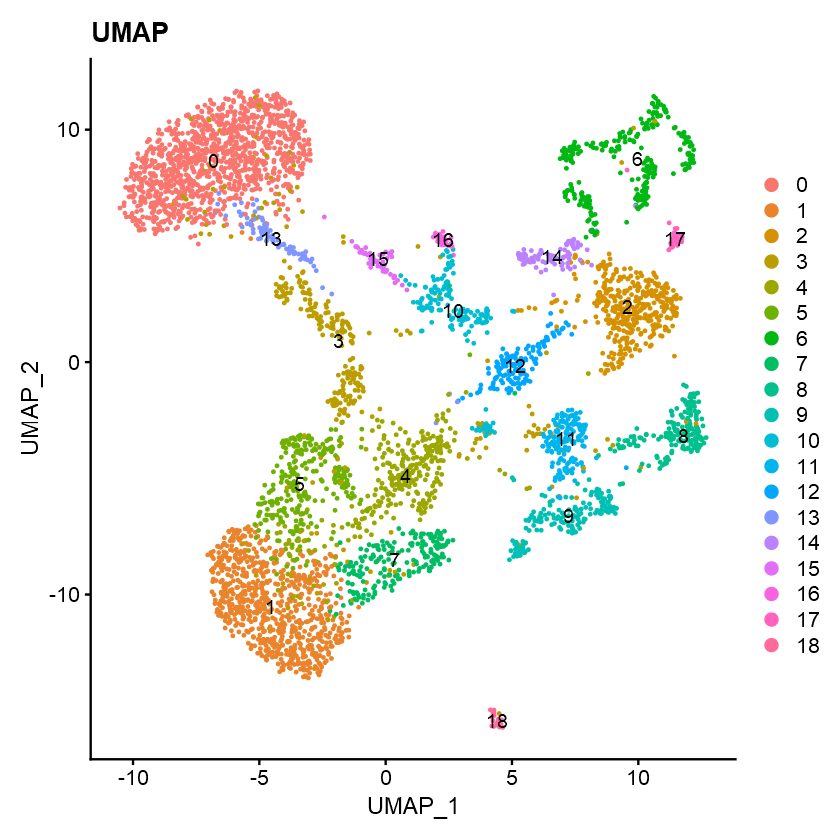

In [105]:
DimPlot(object = SAT_merged_filtered, label = TRUE,reduction = "UMAP", pt.size = 0.3) + ggtitle(label = "UMAP")

In [106]:
SAT_merged_filtered$renames <- SAT_merged_filtered$SCT_snn_res.0.6
Idents(SAT_merged_filtered) <- SAT_merged_filtered$renames
cluster9 <- WhichCells(SAT_merged_filtered,idents = 9)
cluster_ASC_proliferating <- which(UMAP_score_1[match(cluster9,names(UMAP_score_1))] >8)
cluster9 <- setdiff(cluster9,names(cluster_ASC_proliferating))
cluster_ASC_proliferating

AAGAACAAGGAAAGTG-1 ACCTGTCCATGCGGTC-1 ACTTATCAGTCTGGTT-1 AGATCCATCCGGCAGT-1 
                 1                  2                  4                  6 
AGCTACATCTTGTGCC-1 ATCAGGTTCTGGGCGT-1 CACAGATAGATAGGGA-1 CACTTCGCAGAGGACT-1 
                 7                 11                 13                 14 
CCCTTAGCATTGCCTC-1 CGTAAGTAGTATGATG-1 CTGTGGGCAACAGTGG-1 GCCATTCGTTCTCGCT-1 
                16                 18                 20                 23 
GGGTAGAAGCATCTTG-1 GTAAGTCCAACAAGTA-1 GTCTGTCGTCCAATCA-1 TCATCCGCAATGTTGC-1 
                25                 27                 30                 33 
TCTAACTCACACGTGC-1 TGAATGCCATTGGCAT-1 TGAGTCATCGCGTAGC-1 TGTGTGAGTACTTGTG-1 
                34                 35                 36                 38 
TTGCCTGTCACTCACC-1 AAGCATCAGCGCCATC-2 ACGGTCGTCGGATTAC-2 ATGGAGGGTATTGCCA-2 
                41                 47                 53                 67 
ATTCCATCATGAGTAA-2 CACAGGCCAGCTTCCT-2 CAGATTGTCACTGAAC-2 CATTGCCCAGAACTTC-2 
                70                 75                 77                 81 
CCCTGATAGTAAATGC-2 CCGATCTAGGGATCTG-2 CGATCGGGTCAAATCC-2 CGTGAATGTCGGAAAC-2 
                83                 84                 86                 89 
CTAACTTCATGGCACC-2 CTATCCGCAGTTAAAG-2 GAAGAATAGTTGGCGA-2 GTTACCCGTCACTACA-2 
                90                 93                 99                118 
TACATTCTCTTCCCGA-2 TCAAGTGGTAGTTACC-2 TCAATTCTCGAGTACT-2 TCATATCTCCAGCCTT-2 
               125                133                134                137 
TCATTGTCAATTCTTC-2 TCCAGAACAGTCTTCC-2 TCCCACATCGGAGTGA-2 TTACGCCTCGATCCCT-2 
               139                141                143                154 
TTAGGGTCATGGTGGA-2 TTCCTTCTCTCCTGCA-2 TTTGTTGGTCGTATTG-2 
               155                157                159

In [107]:
SAT_merged_filtered <- SetIdent(SAT_merged_filtered,cells = names(cluster_ASC_proliferating), value = "ASC_proliferating")
SAT_merged_filtered <- SetIdent(SAT_merged_filtered,cells = cluster9, value = "9" )

In [108]:
SAT_merged_filtered <- RenameIdents(object = SAT_merged_filtered,`0` = "B-cells",`1` = "T-cells",`2` = "Endothelium", `3`="Proliferating",`4`="Dying",	 `5` = "T-cells", `6` = "Preadipocytes Pdgfrb+", `7` = "T-cells", 
`8`="Preadipocytes Icam1+",`9`= "ASC1 Dpp4+",`10`= "Monocytes",`11`="ASC Cd142+ Pdgfrb+",`12`="ASC Icam1+",`14` = "Endothelium", `15`="Monocytes",`16`="Monocytes",`17` = "Preadipocytes Pdgfrb+")
SAT_merged_filtered$renames <- SAT_merged_filtered@active.ident

In [115]:
##get cluster markers
SAT_merged_filtered.markers <- FindAllMarkers(object = SAT_merged_filtered, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
SAT_merged_filtered.markers %>% group_by(cluster) %>% top_n(n = 8, wt = avg_logFC) -> SAT_merged_filtered_matrix
SAT_merged_filtered_matrix <- data.frame(SAT_merged_filtered_matrix)

Calculating cluster B-cells

Calculating cluster T-cells

Calculating cluster Endothelium

Calculating cluster Proliferating

Calculating cluster Dying

Calculating cluster Preadipocytes Pdgfrb+

Calculating cluster Preadipocytes Icam1+

Calculating cluster ASC1 Dpp4+

Calculating cluster Monocytes

Calculating cluster ASC Cd142+ Pdgfrb+

Calculating cluster ASC Icam1+

Calculating cluster ASC_proliferating

Calculating cluster 13

Calculating cluster 18



In [116]:
##reorder the result##
SAT_merged_filtered_matrix <- SAT_merged_filtered_matrix[order(SAT_merged_filtered_matrix[,6],SAT_merged_filtered_matrix[,2],decreasing =T),]

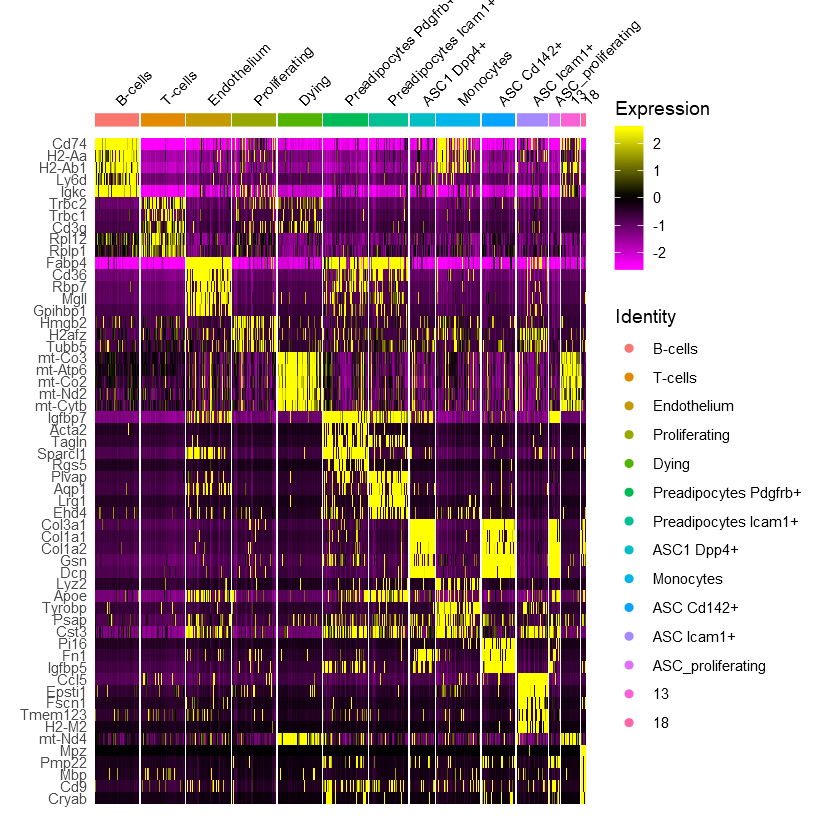

In [96]:
input.list <- SAT_merged_filtered_matrix[order(SAT_merged_filtered_matrix[,6]),]
all_markers_need <- unique(input.list[,7])
##Figure 2E
DoHeatmap(subset(SAT_merged_filtered, downsample = 200),features = all_markers_need, size = 3)

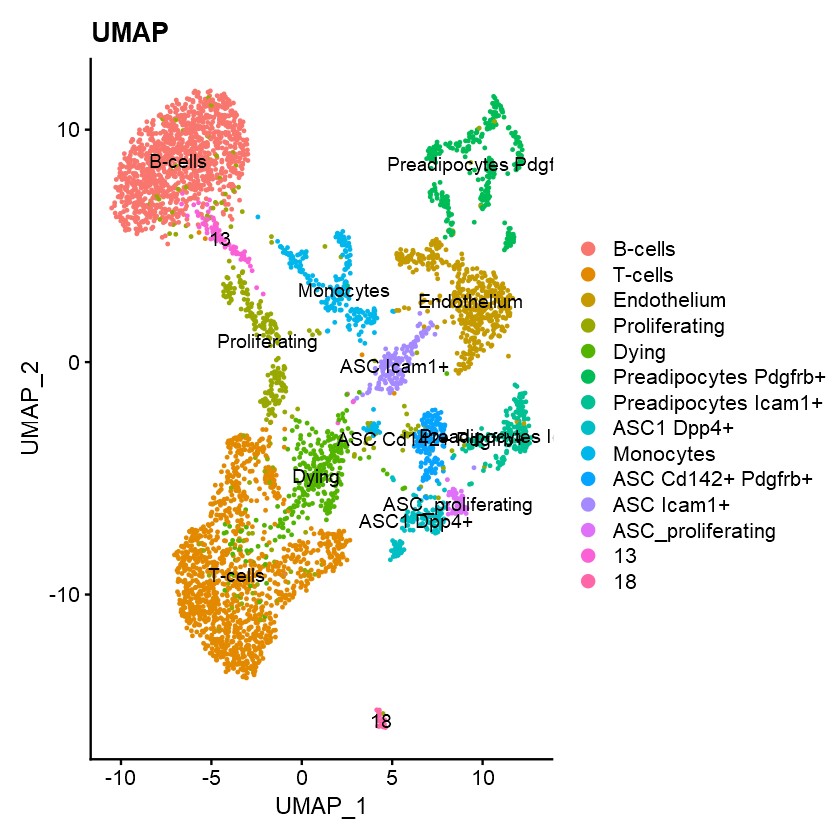

In [111]:
##Figure 2F ## Annotate cell type with featured genes##
DimPlot(object = SAT_merged_filtered, label = TRUE,reduction = "UMAP", pt.size = 0.3) + ggtitle(label = "UMAP")

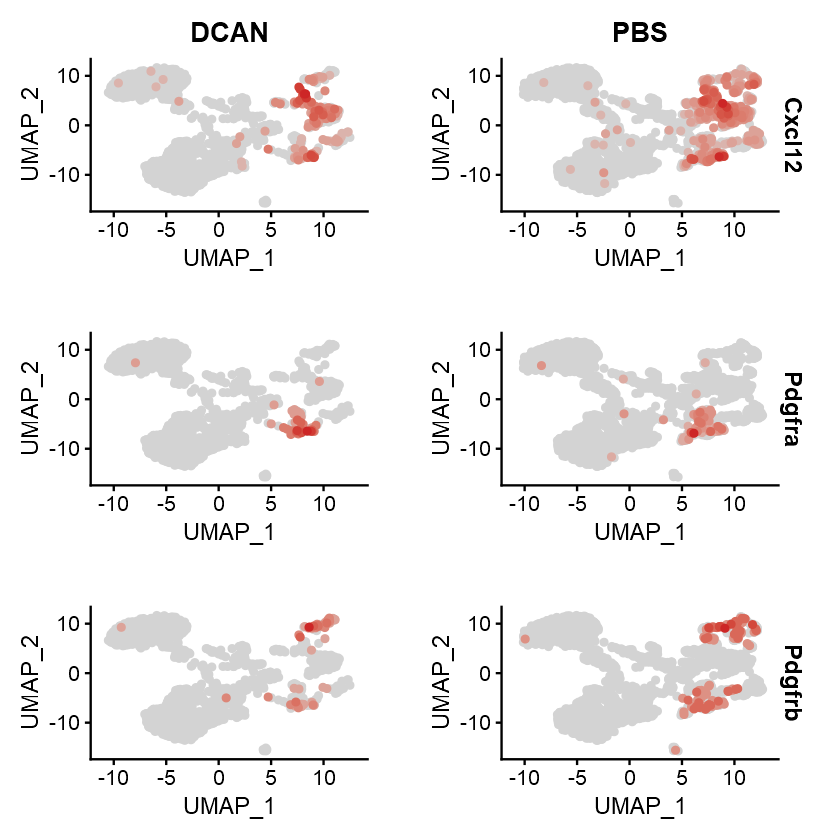

In [114]:
##Figure 2G
FeaturePlot(object = SAT_merged_filtered, features = c("Cxcl12","Pdgfra","Pdgfrb"),cols = c("lightgrey", "firebrick3"), slot="data",split.by = "sample.indent",label = FALSE,pt.size=1.5,order=TRUE)

In [ ]:
##cell proportion calculated from the following commands
cell_prop <- prop.table(x = table(Idents(object = SAT_merged_filtered_renamed_merged),SAT_merged_filtered$sample.indent),margin =2)
cell_prop <- round(cell_prop,3)
##